# Investigating Wordle Data with Twitter API v2

This is an investigation of Wordle data available in tweets through the Twitter API. More specifically, how does the quality of a user's first guess affect the predicted final guess in which they complete the puzzle? First, the most recent 100 tweets were parsed to create a data frame. Then, three prediction methods were used to evaluate the outcome - kNN, logistic regression, and XGBoost.


Guess #1  &emsp;  ⬛⬛⬛🟩⬛  &emsp;→&emsp;  1  &emsp;  green    &emsp;  0  &emsp;  yellow  <br>
Guess #2  &emsp;  🟨⬛⬛🟩⬛  &emsp;→&emsp;  1  &emsp;  green    &emsp;  1  &emsp;  yellow  <br>
Guess #3  &emsp;  🟨🟨⬛🟩⬛  &emsp;→&emsp;  1  &emsp;  green    &emsp;  2  &emsp;  yellow  <br>
Guess #4  &emsp;  ⬛🟨🟨🟩🟨  &emsp;→&emsp;  1  &emsp;  green    &emsp;  3  &emsp;  yellow  <br>
Guess #5  &emsp;  🟩🟩🟩🟩🟩  &emsp;→&emsp;  5  &emsp;  green    &emsp;  0  &emsp;  yellow  <br>
Guess #6  &emsp;  N/A &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; →&emsp;N/A  &emsp;&emsp;&emsp;&emsp;    N/A

In [3]:
import os
import tweepy

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

t_consumer_key    = os.environ.get('t_consumer_key')
t_consumer_secret = os.environ.get('t_consumer_secret')
t_bearer_token    = os.environ.get('t_bearer_token')
t_access_token    = os.environ.get('t_access_token')
t_access_secret   = os.environ.get('t_access_secret')

### Twitter API

In [58]:
wordle_day = 'Wordle 282'   #3/28/2022
client = tweepy.Client(t_bearer_token)

query = wordle_day + ' -is:retweet -Türkçe'
#tweets = tweepy.Paginator(client.search_recent_tweets, query=query, max_results=10).flatten(limit=10)

tweets = client.search_recent_tweets(query=query, max_results=100)

### Parse Tweet


In [59]:
def API_to_DF(tweets):
    df = pd.DataFrame(columns = ['completion', '#1_G', '#1_Y', '#2_G', '#2_Y', '#3_G', '#3_Y',
                                           '#4_G', '#4_Y', '#5_G', '#5_Y', '#6_G', '#6_Y'])
    for tweet in tweets.data:
        df = df.reindex(df.index.tolist() + list(range(df.shape[0], df.shape[0]+1)))

        # find the (start, end) of grid and extract grid
        temp = [tweet.text.find('⬛'),tweet.text.find('⬜'),tweet.text.find('🟨'),tweet.text.find('🟩')]
        if sum(temp) == -4:
            pass
        else:
            l = min([i for i in temp if i >= 0])
        r = max(tweet.text.rfind('⬛'), tweet.text.rfind('⬜'), tweet.text.rfind('🟨'), tweet.text.rfind('🟩'))
        grid = tweet.text[l: r+1]

        # grid max: 6*6=36. ignore tweets that have added additional wordle boxes
        if (len(grid) +1) <= 36:

            # store attempt in which the wordle was completed
            df.iloc[-1, 0] = tweet.text[tweet.text.find('/6') - 1]

            # parse through each guess of the wordle grid. tally green and yellow quantities
            col = 1
            guess_start = 0
            grid_len = len(grid)

            while guess_start < grid_len:        
                guess = grid[guess_start: guess_start+5]

                df.iloc[-1, col]   = guess.count('🟩')
                df.iloc[-1, col+1] = guess.count('🟨') 

                col += 2
                guess_start += 6
                
    df = df[df['#1_G'].notnull()]
    df = df[df['completion'].isin(['1','2','3','4','5','6'])]
    df = df.astype({'#1_G':'float64','#1_Y':'float64','#2_G':'float64','#2_Y':'float64','#3_G':'float64','#3_Y':'float64',
                    '#4_G':'float64','#4_Y':'float64','#5_G':'float64','#5_Y':'float64','#6_G':'float64','#6_Y':'float64',
                    'completion':'category'})
    return df

df = API_to_DF(tweets)

### Train-Test Split

In [60]:
split = int(0.80*df.shape[0])
df_trn = df.iloc[:split, :]
df_tst = df.iloc[split:, :]

y_trn = df_trn['completion']
x_trn = df_trn[['#1_G','#1_Y']]

y_tst = df_tst['completion']
x_tst = df_tst[['#1_G','#1_Y']]

### Visualization of Training Data

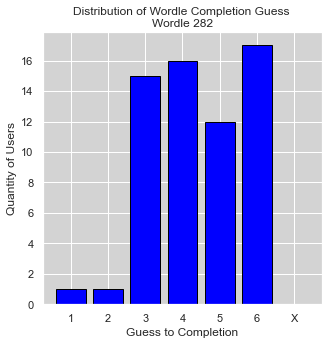

In [61]:
counts = df_trn['completion'].value_counts().reindex(['1','2','3','4','5','6','X'], fill_value = 0 )

sns.set(rc={'axes.facecolor':'lightgray', 'figure.figsize':(5,5)})
plt.bar(counts.index.values, height=counts.values, color='blue', edgecolor='black')
plt.title('Distribution of Wordle Completion Guess \n' + wordle_day)
plt.xlabel('Guess to Completion')
plt.ylabel('Quantity of Users')
plt.show()

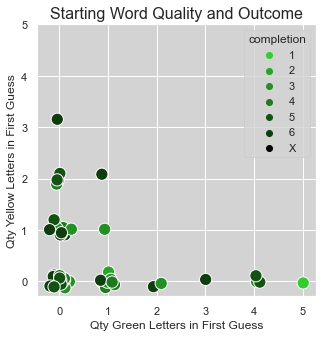

In [73]:
def jitter(x, jitter):
    return x + np.random.normal(loc=0, scale=jitter, size=x.shape)

sns.set(rc={'axes.facecolor':'lightgray', 'figure.figsize':(5,5)})
palette = {'1':'#33cc33', '2':'#29a329', '3':'#248f24', '4':'#1f7a1f', '5':'#145214', '6':'#0f3d0f', 'X':'#000000'}
hue_order = ['1','2','3','4','5','6','X']

plot = sns.scatterplot(x=jitter(df_trn['#1_G'], 0.08), y=jitter(df_trn['#1_Y'], 0.08), 
                       hue=df_trn['completion'], palette=palette, hue_order=hue_order, s=150)

plot.set_xlabel('Qty Green Letters in First Guess', fontsize=12)
plot.set_ylabel('Qty Yellow Letters in First Guess', fontsize=12)
plot.set_title('Starting Word Quality and Outcome', fontsize=16)

plt.xticks([0,1,2,3,4,5])
plt.yticks([0,1,2,3,4,5])
plt.show(plot)

### kNN Classification

We begin with 10 nearest neighbors, without justification.

In [63]:
kNN = KNeighborsClassifier(n_neighbors=10)
kNN.fit(x_trn, y_trn)
y_trn_hat = kNN.predict(x_trn)

print('Train Accuracy: ', round(100*accuracy_score(y_trn, y_trn_hat), 2), '%')

Train Accuracy:  33.87 %


Cross validation is now used to select a value k which minimizes estimated test error.

C:\Users\aheilman\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


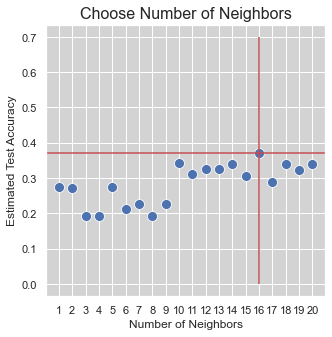

In [65]:
k_range = range(1,21)

kNN = KNeighborsClassifier()
kNN_CV = GridSearchCV(kNN, {'n_neighbors': k_range}, cv=5)
kNN_CV.fit(x_trn, y_trn)

best_k = kNN_CV.best_params_['n_neighbors']
results = kNN_CV.cv_results_['mean_test_score']

plot = sns.scatterplot(x=k_range, y=results, s=100)
plot.vlines(best_k, 0, 0.7, color='r')
plot.axhline(max(results), color='r')

plot.set_xlabel('Number of Neighbors', fontsize=12)
plot.set_ylabel('Estimated Test Accuracy', fontsize=12)
plot.set_title('Choose Number of Neighbors', fontsize=16)

plt.xticks(k_range)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.show(plot)

In [66]:
y_trn_hat = kNN_CV.predict(x_trn)
print('Train Accuracy: ', round(100*accuracy_score(y_trn, y_trn_hat), 2), '%')

y_tst_hat = kNN_CV.predict(x_tst)
print('Test Accuracy: ', round(100*accuracy_score(y_tst, y_tst_hat), 2), '%')

Train Accuracy:  37.1 %
Test Accuracy:  31.25 %


### Multiclass Logistic Regression

In [67]:
lr = LogisticRegression(multi_class='multinomial')
lr.fit(x_trn, y_trn)

y_trn_hat = lr.predict(x_trn)
print('Train Accuracy: ', round(100*accuracy_score(y_trn, y_trn_hat), 2), '%')

y_tst_hat = lr.predict(x_tst)
print('Test Accuracy: ', round(100*accuracy_score(y_tst, y_tst_hat), 2), '%')

Train Accuracy:  37.1 %
Test Accuracy:  50.0 %


In [71]:
print('Completion predictions given quality of first guess')
print('Y | 0G, 0Y: ', lr.predict(pd.DataFrame([{'#1_G':0, '#1_Y':0}]))[0], 'guesses')
print('Y | 1G, 0Y: ', lr.predict(pd.DataFrame([{'#1_G':1, '#1_Y':0}]))[0], 'guesses')
print('Y | 1G, 1Y: ', lr.predict(pd.DataFrame([{'#1_G':1, '#1_Y':1}]))[0], 'guesses')
print('Y | 2G, 1Y: ', lr.predict(pd.DataFrame([{'#1_G':2, '#1_Y':1}]))[0], 'guesses')
print('Y | 3G, 0Y: ', lr.predict(pd.DataFrame([{'#1_G':3, '#1_Y':0}]))[0], 'guesses')
print('Y | 5G, 0Y: ', lr.predict(pd.DataFrame([{'#1_G':5, '#1_Y':0}]))[0], 'guesses')

print('\nNonsensical Result:')
print('Y | 4G, 1Y: ', lr.predict(pd.DataFrame([{'#1_G':4, '#1_Y':1}]))[0], 'guesses')

Completion predictions given quality of first guess
Y | 0G, 0Y:  4 guesses
Y | 1G, 0Y:  3 guesses
Y | 1G, 1Y:  6 guesses
Y | 2G, 1Y:  5 guesses
Y | 3G, 0Y:  3 guesses
Y | 5G, 0Y:  1 guesses

Nonsensical Result:
Y | 4G, 1Y:  5 guesses


### XGBoost

In [72]:
y_trn = y_trn.replace(to_replace='X', value=7)

bst = XGBClassifier(objective='multi:softmax', eval_metric='merror', use_label_encoder=True)
bst.fit(x_trn, y_trn)

y_trn_hat = bst.predict(x_trn)
print('Train Accuracy: ', round(100*accuracy_score(y_trn, y_trn_hat), 2), '%')

y_tst_hat = bst.predict(x_tst)
print('Test Accuracy: ', round(100*accuracy_score(y_tst, y_tst_hat), 2), '%')

Train Accuracy:  41.94 %
Test Accuracy:  37.5 %


C:\Users\aheilman\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
